In [2]:
! pip install seaborn # Install seaborn for data visualization
! pip install open_clip_torch # Install OpenCLIP for image and text embeddings

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached open_clip_torch-3.2.0-py3-none-any.whl.metadata (32 kB)
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached timm-1.0.22-py3-none-any.whl.metadata (63 kB)
Using cached open_clip_torch-3.2.0-py3-none-any.whl (1.5 MB)
Using cached timm-1.0.22-py3-none-any.whl (2.5 MB)
Using cached ftfy-6.3.1-py3-none-any.whl (44 kB)


In [3]:
# Notebook: 06_clip_scene_classifier.ipynb
# Cell 1 - Imports and basic paths

from pathlib import Path
import json

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# You may need: pip install open_clip_torch
import open_clip

DATA_DIR = Path("data")
IMG_DIR = DATA_DIR / "images"
ANN_DIR = DATA_DIR / "annotations"

VAL_JSON = ANN_DIR / "instances_val_gps_split_with_signs.json"
YOLO_FEATURES_CSV = Path("models") / "scene_features_val_from_yolo.csv"

print("Val json exists:", VAL_JSON.exists())
print("YOLO features exists:", YOLO_FEATURES_CSV.exists())


Val json exists: True
YOLO features exists: True


In [4]:
# Notebook: 06_clip_scene_classifier.ipynb
# Cell 2 - Load COCO val and build scene labels

def load_coco(path: Path):
    with open(path, "r") as f:
        return json.load(f)

coco_val = load_coco(VAL_JSON)
images_by_id = {img["id"]: img for img in coco_val["images"]}

def get_scene_label(img_dict):
    tags = img_dict.get("scene_level_tags", {})
    travel_alteration = tags.get("travel_alteration", [])

    if isinstance(travel_alteration, list):
        travel_alteration = travel_alteration[0] if travel_alteration else None

    if travel_alteration is None:
        return None

    txt = str(travel_alteration).lower()
    if "lane shift" in txt:
        return "lane_shift"
    return "workzone_ahead"

labels = []
rows = []
for img in coco_val["images"]:
    sid = img["id"]
    file_name = img["file_name"]
    lbl = get_scene_label(img)
    if lbl is None:
        continue
    labels.append(lbl)
    rows.append({"image_id": sid, "file_name": file_name, "scene_label": lbl})

df_scene = pd.DataFrame(rows)
print(df_scene["scene_label"].value_counts())
df_scene.head()


scene_label
workzone_ahead    2041
lane_shift          56
Name: count, dtype: int64


,image_id,file_name,scene_label
0,1,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,workzone_ahead
1,2,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,workzone_ahead
2,3,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,workzone_ahead
3,4,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,workzone_ahead
4,5,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,workzone_ahead


In [5]:
# Notebook: 06_clip_scene_classifier.ipynb
# Cell 3 - Load YOLO features and merge with scene labels

df_yolo = pd.read_csv(YOLO_FEATURES_CSV)

# Some images may have NaN scene labels, drop those
df_yolo = df_yolo.dropna(subset=["scene_label"])

# Keep only images that are in df_scene
df = pd.merge(
    df_scene,
    df_yolo,
    on=["image_id", "file_name", "scene_label"],
    how="inner",
)

print("Merged table shape:", df.shape)
print(df["scene_label"].value_counts())
df.head()


Merged table shape: (2097, 26)
scene_label
workzone_ahead    2041
lane_shift          56
Name: count, dtype: int64


,image_id,file_name,scene_label,total_objs,count_channelization,frac_channelization,count_workers,frac_workers,count_vehicles,frac_vehicles,...,workers_left,channelization_left,workers_mid,channelization_mid,workers_right,channelization_right,workers_near,channelization_near,workers_far,channelization_far
0,1,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,workzone_ahead,9,3,0.333333,0,0.000000,6,0.666667,...,0,1,0,1,0,0,0,1,0,1
1,2,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,workzone_ahead,21,6,0.285714,14,0.666667,1,0.047619,...,0,0,0,1,7,4,0,0,14,5
2,3,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,workzone_ahead,3,1,0.333333,0,0.000000,2,0.666667,...,0,0,0,0,0,0,0,0,0,1
3,4,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,workzone_ahead,7,2,0.285714,0,0.000000,5,0.714286,...,0,1,0,0,0,0,0,1,0,1
4,5,columbus_ed065d9b86d545b2af0042a058e7e907_0000...,workzone_ahead,5,1,0.200000,0,0.000000,4,0.800000,...,0,0,0,0,0,1,0,0,0,1


In [6]:
# Notebook: 06_clip_scene_classifier.ipynb
# Cell 4 - Load OpenCLIP model

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model_name = "ViT-H-14"    # you can try ViT-B-16 if VRAM is low
pretrained = "laion2b_s32b_b79k"

clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    model_name, pretrained=pretrained, device=device
)
clip_model.eval()

tokenizer = open_clip.get_tokenizer(model_name)


Device: cuda


open_clip_model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

In [7]:
# Notebook: 06_clip_scene_classifier.ipynb
# Cell 5 - Extract CLIP embeddings for all labeled val images

clip_feats = []
img_ids = []
scene_labels = []

with torch.no_grad():
    for _, row in tqdm(df.iterrows(), total=len(df), desc="CLIP features"):
        img_path = IMG_DIR / row["file_name"]
        if not img_path.exists():
            continue

        image = Image.open(img_path).convert("RGB")
        image_input = clip_preprocess(image).unsqueeze(0).to(device)

        image_feat = clip_model.encode_image(image_input)
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)
        image_feat = image_feat.squeeze(0).cpu().numpy()

        clip_feats.append(image_feat)
        img_ids.append(row["image_id"])
        scene_labels.append(row["scene_label"])

clip_feats = np.stack(clip_feats, axis=0)
print("CLIP feature shape:", clip_feats.shape)

df_clip = pd.DataFrame({"image_id": img_ids, "scene_label": scene_labels})

CLIP features:   0%|          | 0/2097 [00:00<?, ?it/s]

CLIP feature shape: (2097, 1024)


In [8]:
# Notebook: 06_clip_scene_classifier.ipynb
# Cell 5b - Optional save CLIP features

np.save("models/clip_scene_features.npy", clip_feats)
df_clip.to_csv("models/clip_scene_meta.csv", index=False)

In [9]:
# Notebook: 06_clip_scene_classifier.ipynb
# Cell 6 - Train and validation splits

label_map = {"workzone_ahead": 0, "lane_shift": 1}
y = np.array([label_map[l] for l in scene_labels], dtype=np.int64)

X_train, X_val, y_train, y_val = train_test_split(
    clip_feats, y, test_size=0.25, random_state=0, stratify=y
)

print("Train size:", X_train.shape[0], "Val size:", X_val.shape[0])
print("Class counts train:", np.bincount(y_train))
print("Class counts val:", np.bincount(y_val))


Train size: 1572 Val size: 525
Class counts train: [1530   42]
Class counts val: [511  14]


In [10]:
# Notebook: 06_clip_scene_classifier.ipynb
# Cell 7 - Train GradientBoosting on CLIP features

from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {c: w for c, w in zip(classes, weights)}

sample_weights_train = np.array([class_weight[yy] for yy in y_train], dtype="float32")

clf_clip = GradientBoostingClassifier(random_state=0)
clf_clip.fit(X_train, y_train, sample_weight=sample_weights_train)

y_pred_val = clf_clip.predict(X_val)

print(classification_report(
    y_val, y_pred_val,
    target_names=["workzone_ahead", "lane_shift"]
))


                precision    recall  f1-score   support

workzone_ahead       0.98      0.99      0.99       511
    lane_shift       0.40      0.14      0.21        14

      accuracy                           0.97       525
     macro avg       0.69      0.57      0.60       525
  weighted avg       0.96      0.97      0.96       525



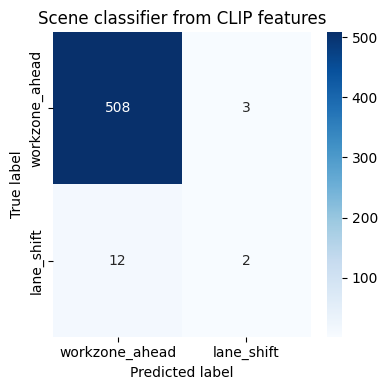

In [11]:
# Notebook: 06_clip_scene_classifier.ipynb
# Cell 8 - Confusion matrix

cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["workzone_ahead", "lane_shift"],
    yticklabels=["workzone_ahead", "lane_shift"],
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Scene classifier from CLIP features")
plt.tight_layout()
plt.show()


In [12]:
# Notebook: 06_clip_scene_classifier.ipynb
# Cell 9 - Fuse CLIP + YOLO features

# First align df_yolo rows to the list of image_ids used in clip_feats
df_yolo_indexed = df_yolo.set_index("image_id")

yolo_feat_cols = [
    c for c in df_yolo_indexed.columns
    if c not in ["file_name", "scene_label"]
]

yolo_array = []
for iid in img_ids:
    row = df_yolo_indexed.loc[iid, yolo_feat_cols]
    yolo_array.append(row.values.astype("float32"))

yolo_array = np.stack(yolo_array, axis=0)
print("YOLO feature shape:", yolo_array.shape)

X_fused = np.concatenate([clip_feats, yolo_array], axis=1)
print("Fused feature shape:", X_fused.shape)

X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(
    X_fused, y, test_size=0.25, random_state=0, stratify=y
)

weights_train_f = compute_class_weight(
    class_weight="balanced", classes=classes, y=y_train_f
)
cw_train_f = {c: w for c, w in zip(classes, weights_train_f)}
sample_weights_train_f = np.array(
    [cw_train_f[yy] for yy in y_train_f], dtype="float32"
)

clf_fused = GradientBoostingClassifier(random_state=0)
clf_fused.fit(X_train_f, y_train_f, sample_weight=sample_weights_train_f)

y_pred_val_f = clf_fused.predict(X_val_f)

print(classification_report(
    y_val_f, y_pred_val_f,
    target_names=["workzone_ahead", "lane_shift"]
))


YOLO feature shape: (2097, 23)
Fused feature shape: (2097, 1047)
                precision    recall  f1-score   support

workzone_ahead       0.98      0.99      0.99       511
    lane_shift       0.40      0.14      0.21        14

      accuracy                           0.97       525
     macro avg       0.69      0.57      0.60       525
  weighted avg       0.96      0.97      0.96       525



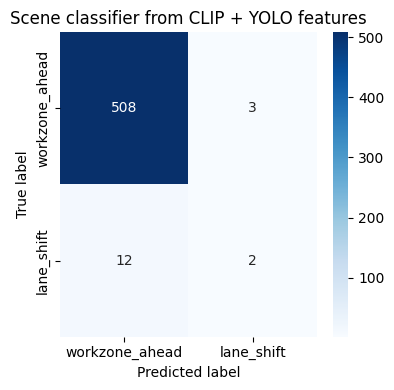

In [13]:
# Notebook: 06_clip_scene_classifier.ipynb
# Cell 10 - Confusion matrix fused model

cm_f = confusion_matrix(y_val_f, y_pred_val_f)
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_f,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["workzone_ahead", "lane_shift"],
    yticklabels=["workzone_ahead", "lane_shift"],
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Scene classifier from CLIP + YOLO features")
plt.tight_layout()
plt.show()